# Chapter 12: Markov Chain Monte Carlo
 
This Jupyter notebook is the Python equivalent of the R code in section 12.4 R, pp. 512 - 517, [Introduction to Probability, 2nd Edition](https://www.crcpress.com/Introduction-to-Probability-Second-Edition/Blitzstein-Hwang/p/book/9781138369917), Blitzstein & Hwang.

----

In [1]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

## Metropolis-Hastings

Here's how to implement the Metropolis-Hastings algorithm for Example 12.1.8, the Normal-Normal model. First, we choose our observed value of $Y$ and decide on values for the constants $\sigma$, $\mu$, and $\tau$:

In [2]:
y = 3
sigma = 1
mu = 0
tau = 2

We also need to choose the standard deviation of the proposals for step 1 of the algorithm, as explained in Example 12.1.8; for this problem, we let $d = 1$. We set the number of iterations to run, and we allocate a NumPy array `theta` of length 10<sup>4</sup> which we will fill with our simulated draws:

In [3]:
d = 1
niter = 10**4
theta = np.zeros(niter)

Now for the main loop. We initialize $\theta$ to the observed value $y$, then run the algorithm described in Example 12.1.8:

In [4]:
theta[0] = y

np.random.seed(1134903170)

from scipy.stats import binom, norm

for i in range(1, niter):
    theta_p = theta[i-1] + norm.rvs(loc=mu, scale=2, size=1)[0]
    numer = norm.pdf(y, loc=theta_p, scale=sigma) * norm.pdf(theta_p, loc=mu, scale=tau)
    denom = norm.pdf(y, loc=theta[i-1], scale=sigma) * norm.pdf(theta[i-1], loc=mu, scale=tau)
    r = numer / denom
    flip = binom.rvs(1, np.min([r, 1]), size=1)[0]
    theta[i] = theta_p if flip==1 else theta[i-1]

Let's step through each line inside the loop. The proposed value of $\theta$ is `theta_p`, which equals the previous value of $\theta$ plus a Normal random variable with mean 0 and standard deviation $d$ (recall that [`scipy.stats.norm.rvs`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html) function takes as parameter `scale` the standard deviation and _not_ the variance). The ratio `r` is

$$
\begin{align}
  \frac{f_{\theta|Y}(x^{\prime}|y)}{f_{\theta|Y}(x|y)} &= \frac{e^{-\frac{1}{2 \, \sigma^2}(y-x^{\prime})^2} \,\, e^{-\frac{1}{2 \, \tau^2}(x^{\prime}-\mu)^2}}{e^{-\frac{1}{2 \, \sigma^2}(y-x)^2} \,\, e^{-\frac{1}{2 \, \tau^2}(x-\mu)^2}}
\end{align}
$$

where `theta_p` is playing the role of $x^{\prime}$ and `theta[i-1]` is playing the role of $x$. The coin flip to determine whether to accept or reject the proposal is `flip`, which is a coin flip with probability `numpy.min([r, 1])` of Heads (encoding Heads as 1 and Tails as 0). Finally, we set `theta[i]` equal to the proposed value if the coin flip lands Heads, or keep it at the previous value otherwise.

The array `theta` now contains all of our simulation draws. We typically discard some of the initial draws to give the chain some time to approach the stationary distribution. The following line of code discards the first half of the draws:

In [5]:
theta = theta[-int(niter/2):]

To see what the remaining draws look like, we can create a histogram using [`matplotlib.axes.Axes.hist`](https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.hist.html) function. We can also compute summary statistics such as `numpy.mean(theta)` and `numpy.var(theta)`, which give us the sample mean and sample variance.

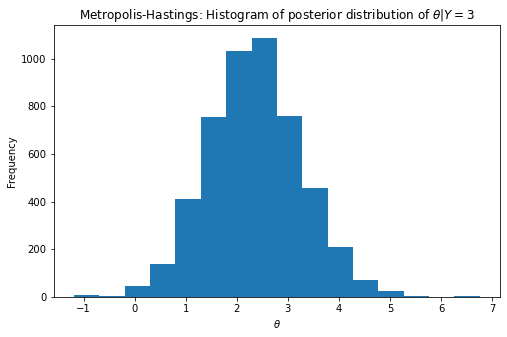

In [6]:
_, ax = plt.subplots(figsize=(8, 5))

ax.hist(theta, bins=16)

ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'Frequency')
ax.set_title(r'Metropolis-Hastings: Histogram of posterior distribution of $\theta | Y=3$')

plt.show()

In [7]:
sample_mean = np.mean(theta)
print('sample mean = {}'.format(sample_mean))

sample_var = np.var(theta, ddof=1)
print('sample var = {}'.format(sample_var))

sample mean = 2.3538455429726186
sample var = 0.8442196578144929


## Gibbs

Now let's implement Gibbs sampling for Example 12.2.6, the chicken-egg problem with unknown hatching probability and invisible unhatched eggs. The first step is to decide on our observed value of $X$, as well as the constants $\lambda$, $a$, $b$:

In [8]:
x = 7
# 'lambda' is a reserved keyword in Python!
lambd = 10 
a = 1 
b = 1

Next we decide how many iterations to run, and we allocate space for our results, creating two NumPy arrays `p` and `N` of length 10<sup>4</sup> which we will fill with our simulated draws:

In [9]:
niter = 10**4 
p = np.zeros(niter) 
N = np.zeros(niter)

Finally, we're ready to run the Gibbs sampler. We initialize `p` and `N` to the values 0.5 and $2x$, respectively, and then we run the algorithm as explained in Example 12.2.6:

In [10]:
p[0] = 0.5 
N[0] = 2*x

np.random.seed(1836311903)

from scipy.stats import beta, poisson
 
for i in range(1, niter):
    p[i] = beta.rvs(x+b, N[i-1]-x+b, size=1)[0]
    N[i] = x + poisson.rvs(lambd*(1-p[i-1]), size=1)[0]

Again, we discard the initial draws:

In [11]:
p = p[-int(niter/2):]
N = N[-int(niter/2):]

To see what the remaining draws look like, we can make histograms using `Axes.hist(p)` and `Axes.hist(N)`, which will result in graphs similar to those R-generated ones in Figure 12.5. We can also compute summary statistics such as `numpy.mean(p)` or `numpy.median(p)`.

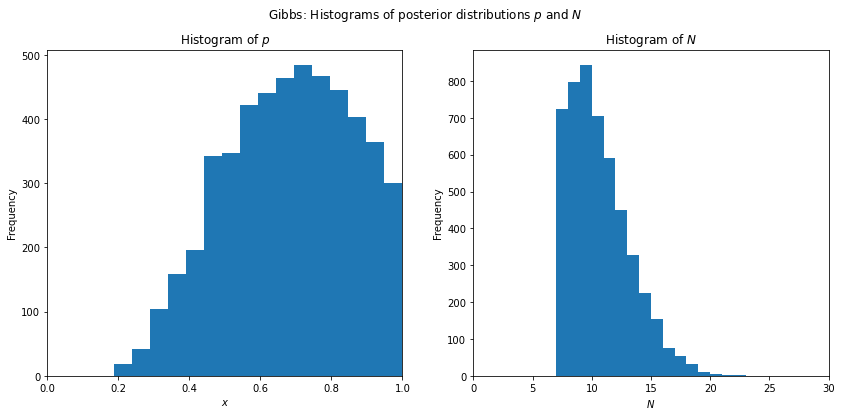

In [12]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# graph for hist(p)
ax1.hist(p, bins=16)
ax1.set_xlim((0,1))
ax1.set_xlabel(r'$x$')
ax1.set_ylabel('Frequency')
ax1.set_title(r'Histogram of $p$')

# graph for hist(N)
ax2.hist(N, bins=16)
ax2.set_xticks(range(0,35,5))
ax2.set_xlabel(r'$N$')
ax2.set_ylabel('Frequency')
ax2.set_title(r'Histogram of $N$')

plt.suptitle(r'Gibbs: Histograms of posterior distributions $p$ and $N$')

plt.show()

In [13]:
mean_p = np.mean(p)
print('mean of p = {}'.format(mean_p))

med_p = np.median(p)
print('median of p = {}'.format(med_p))

mean of p = 0.6822187872541091
median of p = 0.6921336843178136


----

Joseph K. Blitzstein and Jessica Hwang, Harvard University and Stanford University, &copy; 2019 by Taylor and Francis Group, LLC